# import re
import os
import numpy as np
import pandas as pd
import random
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

Median radius ~ 400 nm
Ln(GSD) ~ 0.262
V ~ 24.5 um3/cc
DEHS particles (refractive index = 1.45 + 1e-5i at 532 nm)

These results are for different median size cases, namely, 200 nm, 400 nm, 600 nm and 800 nm. I included another CSV file that has the average number concentration with unit of #/cc. The GSD for these experiment are not exactly known but it is most likely between 1.05 to 1.1. Note that the unit for phase function is 1/Mm 1/str.

n addition to these narrow phase function data, I included another CSV file that has the phase function for a measurement conducted for broad size distribution with median size of 400 nm and GSD 1.4. This could already be included in the current ML model as its GSD is within the training range. Note that both phase function (P11) and polarized phase function (PPF) are include in the same csv file for the broad 400 nm data.
 
 

In [307]:
np.exp(0.262)

1.2995265424293818

# Open Data

In [347]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

In [348]:
directory1 = '/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/paper_results_gaussian_AAE/'


In [4]:
plot_dir = directory1 + 'version5/plots/measurement_data'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

model_dir = directory1 + 'version5/model'

In [5]:
model_name = 'invertible_model'
custom_objects = {'AdjustedRSquared': AdjustedRSquared}
kwargs = {'custom_objects': custom_objects,'compile': False}
surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

In [6]:
data_dir = '/data/user/boiger_r/aerosol/aerosol_data/real_measurement_data_november_2021'
num_con = pd.read_csv(data_dir+"/number_concentration.csv")
phase_fun400 = pd.read_csv(data_dir+"/uNeph_PF_400nm_broad.csv")
#phase_funexp = pd.read_csv(data_dir+"/phase_function_experimental_data.csv")
#phase_funP11 = pd.read_csv(data_dir+"/phase_function_P11.csv")
#phase_funpolar = pd.read_csv(data_dir+'/polar_phase_function.csv')

In [7]:
test_datafile = '/data/user/boiger_r/aerosol/aerosol_data/raw_data_AAE/pre_log_ts-0.2_wl-532_sc-None_qoi-ScatteringData/test_dataset.hdf5'
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')

In [301]:
dvar_test

V_tot  R_median       GSD         n     k_532
75721  2315.678911  1.360143  1.422027  1.345160  0.060143
80184  1121.450456  0.871451  1.422156  1.560918  0.172217
19864  4962.553150  2.033473  1.405489  1.556752  0.179643
76699  4874.291655  0.258148  1.404925  1.331706  0.039514
92991  2536.972303  0.806500  1.444872  1.436442  0.118185
...            ...       ...       ...       ...       ...
32595  4764.529527  1.494872  1.414259  1.333477  0.047427
29313  3534.192530  1.835515  1.405211  1.468337  0.012928
37862  2015.697397  0.385029  1.430910  1.390257  0.042194
53421  3989.475902  1.355483  1.409619  1.563611  0.013500
42410  3102.600374  2.073354  1.426555  1.338385  0.098061

[20000 rows x 5 columns]

In [302]:
qoi_test

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
75721   -15.346368   -15.647405   -15.970624   -16.311292   -16.653436   
80184   -16.014276   -16.163742   -16.331920   -16.516203   -16.713155   
19864   -15.012475   -15.523168   -16.036147   -16.531054   -16.993892   
76699   -15.110576   -15.127886   -15.148264   -15.171547   -15.197773   
92991   -15.174501   -15.305256   -15.452063   -15.612544   -15.783912   
...            ...          ...          ...          ...          ...   
32595   -14.684202   -15.030477   -15.398550   -15.783268   -16.160502   
29313   -15.173373   -15.617139   -16.067307   -16.508342   -16.909186   
37862   -15.379258   -15.411835   -15.449856   -15.493067   -15.541145   
53421   -14.784675   -15.078137   -15.392046   -15.719185   -16.045682   
42410   -15.515366   -16.027250   -16.539644   -17.031266   -17.492659   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
75721    -16.991183    -17.330672    -17.640897    -17.953306    -18.235696   
80184    -16.921192    -17.137610    -17.357178    -17.592391    -17.812220   
19864    -17.371364    -17.737432    -18.033515    -18.265816    -18.461357   
76699    -15.226795    -15.258587    -15.293043    -15.331595    -15.369561   
92991    -15.964517    -16.152045    -16.342427    -16.546712    -16.736172   
...             ...           ...           ...           ...           ...   
32595    -16.518349    -16.876763    -17.199644    -17.509242    -17.786276   
29313    -17.247239    -17.559565    -17.813364    -17.990783    -18.156242   
37862    -15.593900    -15.650971    -15.712164    -15.780053    -15.845553   
53421    -16.366749    -16.678024    -16.959743    -17.213962    -17.454191   
42410    -17.866221    -18.232874    -18.537709    -18.784121    -18.989895   

       ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
75721  ...      -0.008775      -0.020407      -0.026872      -0.026926   
80184  ...      -0.006793       0.002603       0.010576       0.016693   
19864  ...       0.018328       0.016053       0.013968       0.012053   
76699  ...      -0.021345      -0.021064      -0.020148      -0.018704   
92991  ...      -0.115990      -0.101880      -0.085679      -0.068257   
...    ...            ...            ...            ...            ...   
32595  ...      -0.006213      -0.026926      -0.041506      -0.048335   
29313  ...       0.249670       0.243160       0.227130       0.196210   
37862  ...      -0.227540      -0.216710      -0.202010      -0.183830   
53421  ...      -0.109080      -0.129340      -0.156470      -0.187180   
42410  ...      -0.004700      -0.008815      -0.010735      -0.009999   

       P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
75721      -0.019522      -0.004227       0.017765       0.042165   
80184       0.020687       0.022496       0.022268       0.020334   
19864       0.010285       0.008643       0.007115       0.005690   
76699      -0.016848      -0.014699      -0.012379      -0.010006   
92991      -0.050761      -0.034486      -0.020627      -0.010009   
...              ...            ...            ...            ...   
32595      -0.045739      -0.032134      -0.006891       0.027376   
29313       0.154640       0.109550       0.064009       0.022482   
37862      -0.162800      -0.139800      -0.115890      -0.092175   
53421      -0.218290      -0.245920      -0.264810      -0.268930   
42410      -0.006514      -0.000717       0.006341       0.013076   

       P12_0.532_174  P12_0.532_175  
75721       0.061166       0.066825  
80184       0.017159       0.013279  
19864       0.004370       0.003168  
76699      -0.007694      -0.005548  
92991      -0.002906       0.000969  
...              ...            ...  
32595       0.061539       0.080851  
29313      -0.011816      -0.034087  
37862      -0.069719      -0.049461  
53421      -0.252300      -0.212900  
42410       0.017739       0.0190

Real measurement data

In [349]:
phase_fun400

angle    P11 [1/um]  -P12/P11
0      3.0 -1.362595e-10 -1.480170
1      4.0 -8.195502e-11 -5.891817
2      5.0  2.811317e-10 -0.051803
3      6.0  2.427819e-10  0.002813
4      7.0  2.753020e-10  0.016807
..     ...           ...       ...
169  173.0  5.147550e-12 -0.011733
170  174.0  5.379664e-12  0.003998
171  175.0  5.898060e-12 -0.014041
172  176.0  6.592036e-12 -0.009016
173  177.0  9.440054e-12  0.015246

[174 rows x 3 columns]

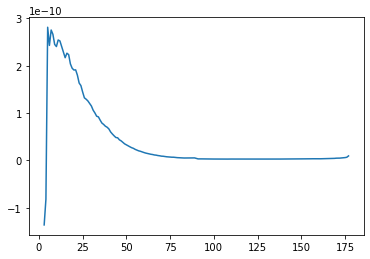

In [41]:
plt.plot(phase_fun400['angle'],phase_fun400['P11 [1/um]'])

/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


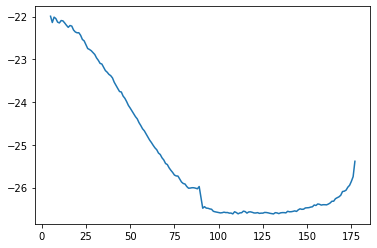

In [42]:
plt.plot(phase_fun400['angle'],np.log(phase_fun400['P11 [1/um]']))

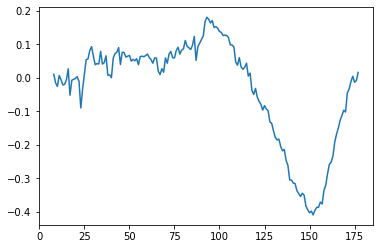

In [45]:
plt.plot(phase_fun400['angle'].iloc[5:],phase_fun400['-P12/P11'].iloc[5:])

In [10]:
phase400new_P11 = pd.DataFrame(data = phase_fun400['P11 [1/um]']).transpose()
phase400new_P12 = pd.DataFrame(data = phase_fun400['-P12/P11']).transpose()

In [121]:
listindex = []
for i in range(len(phase_fun400['angle'])):
    listindex.append("P11_0.532_"+str(int(phase_fun400['angle'].iloc[i])))
listindex2 = []
for i in range(len(phase_fun400['angle'])):
    listindex2.append("P12_0.532_"+str(int(phase_fun400['angle'].iloc[i])))
    

In [350]:

dicts = {}
keys = phase400new_P11.columns
j = 0
for i in phase400new_P11.columns:
        dicts[i] = listindex[j]
        j=j+1


dicts2 = {}
keys2 = phase400new_P12.columns
j = 0
for i in phase400new_P12.columns:
        dicts2[i] = listindex2[j]
        j=j+1

In [125]:
newpdP11 = phase400new_P11.rename(dicts,axis = 1)
newpdP12 = phase400new_P12.rename(dicts2,axis = 1)

In [126]:
newpdP12 = newpdP12.rename({'-P12/P11':'0'},axis = 0)
newpdP11 = newpdP11.rename({'P11 [1/um]':'0'},axis = 0)

In [127]:
newpdP11['P11_0.532_173'] = newpdP11['P11_0.532_176']
newpdP11['P11_0.532_174'] = newpdP11['P11_0.532_177']
newpdP11['P11_0.532_175'] = newpdP11['P11_0.532_177']

In [130]:
newpdP12

P12_0.532_3  P12_0.532_4  P12_0.532_5  P12_0.532_6  P12_0.532_7  \
0     -1.48017    -5.891817    -0.051803     0.002813     0.016807   

   P12_0.532_8  P12_0.532_9  P12_0.532_10  P12_0.532_11  P12_0.532_12  ...  \
0     0.009994    -0.015661     -0.026478      0.006169     -0.006233  ...   

   P12_0.532_168  P12_0.532_169  P12_0.532_170  P12_0.532_171  P12_0.532_172  \
0      -0.113302      -0.097383      -0.102803      -0.045366      -0.034427   

   P12_0.532_173  P12_0.532_174  P12_0.532_175  P12_0.532_176  P12_0.532_177  
0      -0.011733       0.003998      -0.014041      -0.009016       0.015246  

[1 rows x 174 columns]

In [132]:
newpdP12['P12_0.532_173'] = newpdP12['P12_0.532_176']
newpdP12['P12_0.532_174'] = newpdP12['P12_0.532_177']
newpdP12['P12_0.532_175'] = newpdP12['P12_0.532_177']

In [134]:
newpdP11_s = newpdP11.drop(['P11_0.532_3'],axis =1)

In [135]:
newpdP11_s = newpdP11.drop(['P11_0.532_3','P11_0.532_4','P11_0.532_176','P11_0.532_177'],axis = 1)

In [136]:
newpdP11_s = newpdP11_s.drop(['P11_0.532_85','P11_0.532_86','P11_0.532_87','P11_0.532_88','P11_0.532_89','P11_0.532_91','P11_0.532_92','P11_0.532_93','P11_0.532_94','P11_0.532_95'],axis =1)


In [137]:
newpdP11_s = np.log(newpdP11_s)

In [138]:
newpdP12_s = newpdP12.drop(['P12_0.532_3','P12_0.532_4','P12_0.532_176','P12_0.532_177'],axis = 1)

In [139]:
newpdP12_s =newpdP12_s.drop(['P12_0.532_85','P12_0.532_86','P12_0.532_87','P12_0.532_88','P12_0.532_89','P12_0.532_91','P12_0.532_92','P12_0.532_93','P12_0.532_94','P12_0.532_95'],axis =1)


In [140]:
newpdP12_s

P12_0.532_5  P12_0.532_6  P12_0.532_7  P12_0.532_8  P12_0.532_9  \
0    -0.051803     0.002813     0.016807     0.009994    -0.015661   

   P12_0.532_10  P12_0.532_11  P12_0.532_12  P12_0.532_13  P12_0.532_14  ...  \
0     -0.026478      0.006169     -0.006233     -0.021966     -0.020498  ...   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  \
0      -0.150502      -0.127397      -0.113302      -0.097383      -0.102803   

   P12_0.532_171  P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  
0      -0.045366      -0.034427      -0.009016       0.015246       0.015246  

[1 rows x 160 columns]

In [141]:
phase400new = pd.concat([newpdP11_s,newpdP12_s],axis =1)

# Reformatted Real Measurement data

In [142]:
phase400new

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0   -21.992198   -22.138857   -22.013152   -22.046841   -22.130284   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0    -22.148891    -22.092726    -22.100672    -22.149605     -22.20426  ...   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  \
0      -0.150502      -0.127397      -0.113302      -0.097383      -0.102803   

   P12_0.532_171  P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  
0      -0.045366      -0.034427      -0.009016       0.015246       0.015246  

[1 rows x 320 columns]

# Predict dvar from measurement data

In [143]:
dvar_pred_iv = surr.sample_n_tries(phase400new.values, batch_size=128, n_tries=1)


In [144]:
dvar_pred_iv

array([[2.97726015e+04, 1.02364104e+01, 1.51908770e+00, 2.89678356e+00,
        9.79826340e-01]])

In [145]:
dvar_pred_iv = pd.DataFrame(data=dvar_pred_iv, columns=dvar_test.columns)
dvar_pred_iv

V_tot  R_median       GSD         n     k_532
0  29772.601549  10.23641  1.519088  2.896784  0.979826

# Compare to true values

In [308]:
Parameters1 = pd.DataFrame([])
n = 1.45
k = 1e-5
m = n+1j*k
sigma = np.exp(0.262)
rmean = 0.4
Vtot = 24.5
wavelength = 532
#Parameters1['RealRefractiveIndex']=[n]
#Parameters1['ImaginaryRefractiveIndex']= k
#Parameters1['Sigma']=sigma
#Parameters1['MeanRadius']=rmean
#Parameters1['VolumeConcentration']=Vtot

In [309]:
Parameters1['V_tot']=[Vtot]
Parameters1['R_median']=rmean
Parameters1['GSD']=sigma
Parameters1['n']=n
Parameters1['k_532']=k

In [310]:
Parameters1

V_tot  R_median       GSD     n    k_532
0   24.5       0.4  1.299527  1.45  0.00001

In [358]:
# Parameter k_532 is not included in the original data set. 

## Find the parameter that is closest to the measured aerosols

In [359]:
diff_dvar = dvar_test-Parameters1.values

In [360]:

norm_dvar = diff_dvar.apply(np.linalg.norm, axis=1)
idxmin_dvar = norm_dvar.idxmin()

dvar_test.loc[idxmin_dvar]

V_tot       24.431016
R_median     0.408640
GSD          1.435108
n            1.410556
k_532        0.051486
Name: 30040, dtype: float64

# Predict the phase functions from the measured parameter set

In [362]:
qoi_pred_iv_meas = surr.predict(Parameters1)

In [366]:
Parameters2= pd.DataFrame(dvar_test.loc[idxmin_dvar].values,columns=dvar_test.columns)

ValueError: Shape of passed values is (5, 1), indices imply (5, 5)

In [365]:
qoi_pred_iv_meas_close = surr.predict(dvar_test.loc[idxmin_dvar])

ValueError: Expected 2D array, got 1D array instead:
array=[24.43101591  0.40863955  1.43510779  1.41055629  0.05148569].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [316]:
qoi_pred_iv_df = pd.DataFrame(qoi_pred_iv,columns = qoi_test.columns)

In [317]:
qoi_pred_iv_df

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0   -20.508264   -20.330279   -20.380855   -20.500929   -20.473666   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0    -20.500851    -20.565261    -20.779232    -20.700245    -20.806329  ...   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  \
0      -0.528601      -0.517255       -0.47967      -0.461651      -0.415795   

   P12_0.532_171  P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  
0      -0.347489      -0.297057      -0.231694      -0.153259      -0.113939  

[1 rows x 320 columns]

In [246]:
np.log((phase_fun400['P11']/(1e+9))).describe()

KeyError: 'P11'

In [247]:
plt.plot(phase_fun400['angle'],np.log(phase_fun400['P11']/(1e+10)),'.')

KeyError: 'P11'

In [318]:
qoi_test[P11_column_names].describe()

P11_0.532_5   P11_0.532_6   P11_0.532_7   P11_0.532_8   P11_0.532_9  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean     -15.752014    -16.042350    -16.339971    -16.634126    -16.919093   
std        1.044242      1.096547      1.172695      1.258449      1.346876   
min      -23.400995    -23.934223    -24.459866    -24.952125    -25.406462   
25%      -16.194000    -16.538068    -16.916248    -17.314241    -17.699712   
50%      -15.492024    -15.836117    -16.175804    -16.502399    -16.821576   
75%      -15.013858    -15.256525    -15.484261    -15.689728    -15.884467   
max      -14.152411    -14.202925    -14.261282    -14.326936    -14.399230   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean     -17.175763    -17.427254    -17.649306    -17.851162    -18.033961   
std        1.417177      1.487137      1.541801      1.579622      1.612336   
min      -25.769098    -26.119946    -26.398432    -26.601687    -26.776308   
25%      -18.030076    -18.349943    -18.619427    -18.847135    -19.045931   
50%      -17.125872    -17.426985    -17.692070    -17.933052    -18.151990   
75%      -16.076066    -16.270717    -16.453656    -16.634277    -16.801050   
max      -14.477508    -14.561067    -14.637742    -14.679660    -14.720787   

       ...  P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  \
count  ...   20000.000000   20000.000000   20000.000000   20000.000000   
mean   ...     -22.530995     -22.528457     -22.529381     -22.531924   
std    ...       1.690728       1.693499       1.697927       1.704907   
min    ...     -31.361598     -31.368965     -31.378844     -31.390624   
25%    ...     -23.636340     -23.635383     -23.638585     -23.642760   
50%    ...     -22.616294     -22.619053     -22.626471     -22.633809   
75%    ...     -21.285999     -21.288614     -21.288715     -21.279368   
max    ...     -18.093826     -18.024727     -17.942647     -17.856845   

       P11_0.532_170  P11_0.532_171  P11_0.532_172  P11_0.532_173  \
count   20000.000000   20000.000000   20000.000000   20000.000000   
mean      -22.536028     -22.541863     -22.546369     -22.547851   
std         1.714267       1.725101       1.737592       1.749979   
min       -31.403195     -31.415267     -31.425394     -31.432442   
25%       -23.652756     -23.665154     -23.680937     -23.690367   
50%       -22.649025     -22.664303     -22.673294     -22.681800   
75%       -21.272243     -21.266412     -21.261368     -21.263057   
max       -17.769919     -17.684378     -17.602488     -17.526186   

       P11_0.532_174  P11_0.532_175  
count   20000.000000   20000.000000  
mean      -22.542877     -22.528691  
std         1.761039       1.769329  
min       -31.435760     -31.435401  
25%       -23.695721     -23.689168  
50%       -22.683290     -22.667617  
75%       -21.250386     -21.234833  
max       -17.457049     -17.396397  

[8 rows x 160 columns]

In [319]:
P11_column_names = list(filter(re.compile(".*P11").match, qoi_test.columns))
P12_column_names = list(filter(re.compile(".*P12").match, qoi_test.columns))
P11_column_names

['P11_0.532_5',
 'P11_0.532_6',
 'P11_0.532_7',
 'P11_0.532_8',
 'P11_0.532_9',
 'P11_0.532_10',
 'P11_0.532_11',
 'P11_0.532_12',
 'P11_0.532_13',
 'P11_0.532_14',
 'P11_0.532_15',
 'P11_0.532_16',
 'P11_0.532_17',
 'P11_0.532_18',
 'P11_0.532_19',
 'P11_0.532_20',
 'P11_0.532_21',
 'P11_0.532_22',
 'P11_0.532_23',
 'P11_0.532_24',
 'P11_0.532_25',
 'P11_0.532_26',
 'P11_0.532_27',
 'P11_0.532_28',
 'P11_0.532_29',
 'P11_0.532_30',
 'P11_0.532_31',
 'P11_0.532_32',
 'P11_0.532_33',
 'P11_0.532_34',
 'P11_0.532_35',
 'P11_0.532_36',
 'P11_0.532_37',
 'P11_0.532_38',
 'P11_0.532_39',
 'P11_0.532_40',
 'P11_0.532_41',
 'P11_0.532_42',
 'P11_0.532_43',
 'P11_0.532_44',
 'P11_0.532_45',
 'P11_0.532_46',
 'P11_0.532_47',
 'P11_0.532_48',
 'P11_0.532_49',
 'P11_0.532_50',
 'P11_0.532_51',
 'P11_0.532_52',
 'P11_0.532_53',
 'P11_0.532_54',
 'P11_0.532_55',
 'P11_0.532_56',
 'P11_0.532_57',
 'P11_0.532_58',
 'P11_0.532_59',
 'P11_0.532_60',
 'P11_0.532_61',
 'P11_0.532_62',
 'P11_0.532_63',
 '

In [356]:
qoi_test.describe()

P11_0.532_5   P11_0.532_6   P11_0.532_7   P11_0.532_8   P11_0.532_9  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean     -15.752014    -16.042350    -16.339971    -16.634126    -16.919093   
std        1.044242      1.096547      1.172695      1.258449      1.346876   
min      -23.400995    -23.934223    -24.459866    -24.952125    -25.406462   
25%      -16.194000    -16.538068    -16.916248    -17.314241    -17.699712   
50%      -15.492024    -15.836117    -16.175804    -16.502399    -16.821576   
75%      -15.013858    -15.256525    -15.484261    -15.689728    -15.884467   
max      -14.152411    -14.202925    -14.261282    -14.326936    -14.399230   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean     -17.175763    -17.427254    -17.649306    -17.851162    -18.033961   
std        1.417177      1.487137      1.541801      1.579622      1.612336   
min      -25.769098    -26.119946    -26.398432    -26.601687    -26.776308   
25%      -18.030076    -18.349943    -18.619427    -18.847135    -19.045931   
50%      -17.125872    -17.426985    -17.692070    -17.933052    -18.151990   
75%      -16.076066    -16.270717    -16.453656    -16.634277    -16.801050   
max      -14.477508    -14.561067    -14.637742    -14.679660    -14.720787   

       ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
count  ...   20000.000000   20000.000000   20000.000000   20000.000000   
mean   ...      -0.105301      -0.103885      -0.100766      -0.096017   
std    ...       0.185790       0.176725       0.166040       0.152955   
min    ...      -0.639540      -0.621930      -0.595210      -0.570720   
25%    ...      -0.207660      -0.201153      -0.191600      -0.179792   
50%    ...      -0.051160      -0.052344      -0.052525      -0.051206   
75%    ...       0.003927       0.000400      -0.001498      -0.002567   
max    ...       0.568690       0.581320       0.584930       0.561040   

       P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
count   20000.000000   20000.000000   20000.000000   20000.000000   
mean       -0.089323      -0.080539      -0.069704      -0.057010   
std         0.138148       0.122390       0.105933       0.090044   
min        -0.531340      -0.475830      -0.415630      -0.351730   
25%        -0.164925      -0.147623      -0.128103      -0.106703   
50%        -0.047327      -0.042125      -0.035580      -0.029487   
75%        -0.001958       0.000586       0.005309       0.007007   
max         0.522760       0.484560       0.410460       0.360220   

       P12_0.532_174  P12_0.532_175  
count   20000.000000   20000.000000  
mean       -0.043299      -0.029895  
std         0.075687       0.063720  
min        -0.339120      -0.315290  
25%        -0.083535      -0.061469  
50%        -0.021829      -0.014176  
75%         0.007546       0.007559  
max         0.273460       0.148490  

[8 rows x 320 columns]

In [368]:
np.exp(qoi_test[P11_column_names].loc[75721])

P11_0.532_5      2.163500e-07
P11_0.532_6      1.601100e-07
P11_0.532_7      1.158900e-07
P11_0.532_8      8.243200e-08
P11_0.532_9      5.854700e-08
                     ...     
P11_0.532_171    7.256200e-11
P11_0.532_172    6.568800e-11
P11_0.532_173    5.996400e-11
P11_0.532_174    5.638700e-11
P11_0.532_175    5.552100e-11
Name: 75721, Length: 160, dtype: float64

In [354]:
plt.plot(qoi_test[P11_column_names].loc[75721])

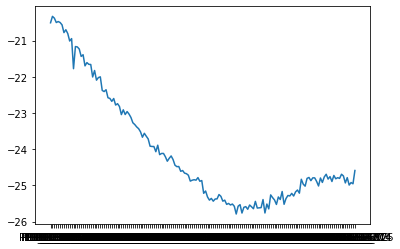

In [321]:
plt.plot(qoi_pred_iv_df[P11_column_names].iloc[0])

In [322]:
plt.plot(qoi_pred_iv_df[P12_column_names].iloc[0])

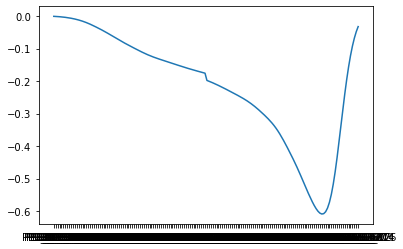

In [323]:
plt.plot(qoi_test[P12_column_names].iloc[1000])

In [324]:
diff_qoi_P11 = qoi_test[P11_column_names] -phase400new[P11_column_names].values


norm_df_P11 = diff_qoi_P11.apply(np.linalg.norm, axis=1)
idxmin_P11 = norm_df_P11.idxmin()

ind_P11 = qoi_test[P11_column_names].loc[idxmin_P11]

In [325]:
ind_P11

P11_0.532_5     -18.874480
P11_0.532_6     -19.459535
P11_0.532_7     -20.010267
P11_0.532_8     -20.493425
P11_0.532_9     -20.896215
                   ...    
P11_0.532_171   -25.524025
P11_0.532_172   -25.506164
P11_0.532_173   -25.534391
P11_0.532_174   -25.609619
P11_0.532_175   -25.717974
Name: 87575, Length: 160, dtype: float64

In [326]:
qoi_test

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
75721   -15.346368   -15.647405   -15.970624   -16.311292   -16.653436   
80184   -16.014276   -16.163742   -16.331920   -16.516203   -16.713155   
19864   -15.012475   -15.523168   -16.036147   -16.531054   -16.993892   
76699   -15.110576   -15.127886   -15.148264   -15.171547   -15.197773   
92991   -15.174501   -15.305256   -15.452063   -15.612544   -15.783912   
...            ...          ...          ...          ...          ...   
32595   -14.684202   -15.030477   -15.398550   -15.783268   -16.160502   
29313   -15.173373   -15.617139   -16.067307   -16.508342   -16.909186   
37862   -15.379258   -15.411835   -15.449856   -15.493067   -15.541145   
53421   -14.784675   -15.078137   -15.392046   -15.719185   -16.045682   
42410   -15.515366   -16.027250   -16.539644   -17.031266   -17.492659   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
75721    -16.991183    -17.330672    -17.640897    -17.953306    -18.235696   
80184    -16.921192    -17.137610    -17.357178    -17.592391    -17.812220   
19864    -17.371364    -17.737432    -18.033515    -18.265816    -18.461357   
76699    -15.226795    -15.258587    -15.293043    -15.331595    -15.369561   
92991    -15.964517    -16.152045    -16.342427    -16.546712    -16.736172   
...             ...           ...           ...           ...           ...   
32595    -16.518349    -16.876763    -17.199644    -17.509242    -17.786276   
29313    -17.247239    -17.559565    -17.813364    -17.990783    -18.156242   
37862    -15.593900    -15.650971    -15.712164    -15.780053    -15.845553   
53421    -16.366749    -16.678024    -16.959743    -17.213962    -17.454191   
42410    -17.866221    -18.232874    -18.537709    -18.784121    -18.989895   

       ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
75721  ...      -0.008775      -0.020407      -0.026872      -0.026926   
80184  ...      -0.006793       0.002603       0.010576       0.016693   
19864  ...       0.018328       0.016053       0.013968       0.012053   
76699  ...      -0.021345      -0.021064      -0.020148      -0.018704   
92991  ...      -0.115990      -0.101880      -0.085679      -0.068257   
...    ...            ...            ...            ...            ...   
32595  ...      -0.006213      -0.026926      -0.041506      -0.048335   
29313  ...       0.249670       0.243160       0.227130       0.196210   
37862  ...      -0.227540      -0.216710      -0.202010      -0.183830   
53421  ...      -0.109080      -0.129340      -0.156470      -0.187180   
42410  ...      -0.004700      -0.008815      -0.010735      -0.009999   

       P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
75721      -0.019522      -0.004227       0.017765       0.042165   
80184       0.020687       0.022496       0.022268       0.020334   
19864       0.010285       0.008643       0.007115       0.005690   
76699      -0.016848      -0.014699      -0.012379      -0.010006   
92991      -0.050761      -0.034486      -0.020627      -0.010009   
...              ...            ...            ...            ...   
32595      -0.045739      -0.032134      -0.006891       0.027376   
29313       0.154640       0.109550       0.064009       0.022482   
37862      -0.162800      -0.139800      -0.115890      -0.092175   
53421      -0.218290      -0.245920      -0.264810      -0.268930   
42410      -0.006514      -0.000717       0.006341       0.013076   

       P12_0.532_174  P12_0.532_175  
75721       0.061166       0.066825  
80184       0.017159       0.013279  
19864       0.004370       0.003168  
76699      -0.007694      -0.005548  
92991      -0.002906       0.000969  
...              ...            ...  
32595       0.061539       0.080851  
29313      -0.011816      -0.034087  
37862      -0.069719      -0.049461  
53421      -0.252300      -0.212900  
42410       0.017739       0.0190

In [327]:
diff_qoi_P12 = qoi_test[P12_column_names] -phase400new[P12_column_names].values


norm_df_P12 = diff_qoi_P12.apply(np.linalg.norm, axis=1)
idxmin_P12 =norm_df_P12.idxmin()
ind_P12 = qoi_test[P12_column_names].loc[idxmin_P12]

In [328]:
diff_qoi = qoi_test -phase400new.values


norm_df = diff_qoi.apply(np.linalg.norm, axis=1)
idxmin = norm_df.idxmin()
ind = qoi_test.loc[idxmin]

In [329]:
qoi_test.loc[idxmin]

P11_0.532_5     -20.103442
P11_0.532_6     -20.224857
P11_0.532_7     -20.362380
P11_0.532_8     -20.513816
P11_0.532_9     -20.676669
                   ...    
P12_0.532_171    -0.361230
P12_0.532_172    -0.294900
P12_0.532_173    -0.225210
P12_0.532_174    -0.160450
P12_0.532_175    -0.106140
Name: 86954, Length: 320, dtype: float64

In [330]:
idxmin_P12

19349

In [331]:
idxmin_P11

87575

In [332]:
idxmin

86954

In [333]:
Parameters1

V_tot  R_median       GSD     n    k_532
0   24.5       0.4  1.299527  1.45  0.00001

In [334]:
dvar_test.loc[idxmin]

V_tot       17.853927
R_median     0.780380
GSD          1.420669
n            1.464857
k_532        0.055768
Name: 86954, dtype: float64

In [335]:
pd.DataFrame([dvar_test.loc[idxmin]],columns = Parameters1.columns)

V_tot  R_median       GSD         n     k_532
86954  17.853927   0.78038  1.420669  1.464857  0.055768

In [336]:
dvar_test.loc[idxmin_P11]
pd.DataFrame([dvar_test.loc[idxmin_P11]],columns = Parameters1.columns)

V_tot  R_median       GSD         n     k_532
87575  143.58364  2.465289  1.425382  1.330004  0.017115

In [337]:
dvar_test.loc[idxmin_P12]

V_tot       1926.627373
R_median       0.213462
GSD            1.410217
n              1.507195
k_532          0.001514
Name: 19349, dtype: float64

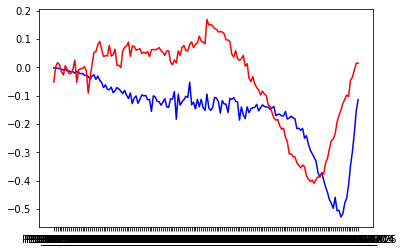

In [346]:
plt.plot(qoi_pred_iv_df[P12_column_names].iloc[0],'b')
plt.plot(phase400new[P12_column_names].iloc[0],'r')


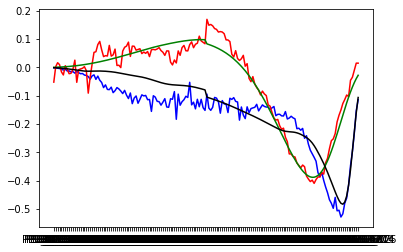

In [338]:
plt.plot(qoi_pred_iv_df[P12_column_names].iloc[0],'b')
plt.plot(phase400new[P12_column_names].iloc[0],'r')
plt.plot(qoi_test[P12_column_names].loc[idxmin_P12],'g')
plt.plot(ind[P12_column_names],'k')

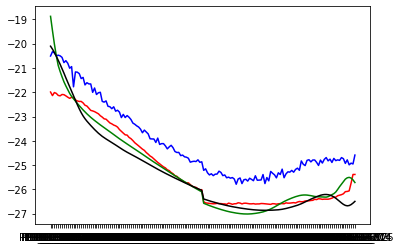

In [339]:
plt.plot(qoi_pred_iv_df[P11_column_names].iloc[0],'b')
plt.plot(phase400new[P11_column_names].iloc[0],'r')
plt.plot(qoi_test[P11_column_names].loc[idxmin_P11],'g')
plt.plot(ind[P11_column_names],'k')

In [340]:
qoi_test[P12_column_names]

P12_0.532_5  P12_0.532_6  P12_0.532_7  P12_0.532_8  P12_0.532_9  \
75721    -0.000212    -0.000248    -0.000190     0.000064     0.000662   
80184     0.002410     0.003460     0.004716     0.006203     0.007952   
19864     0.007522     0.011886     0.018186     0.027069     0.039164   
76699     0.001388     0.002001     0.002728     0.003570     0.004527   
92991     0.001098     0.001538     0.002036     0.002589     0.003192   
...            ...          ...          ...          ...          ...   
32595    -0.000807    -0.001035    -0.001111    -0.000853     0.000024   
29313    -0.002582    -0.002918    -0.002416    -0.000478     0.003425   
37862    -0.000002    -0.000003    -0.000004    -0.000005    -0.000006   
53421    -0.002319    -0.003005    -0.003489    -0.003552    -0.002884   
42410     0.003720     0.005911     0.009207     0.014048     0.020952   

       P12_0.532_10  P12_0.532_11  P12_0.532_12  P12_0.532_13  P12_0.532_14  \
75721      0.001792      0.003709      0.006547      0.010526      0.016053   
80184      0.010015      0.012447      0.015278      0.018776      0.022705   
19864      0.052492      0.070188      0.088159      0.104870      0.119820   
76699      0.005602      0.006795      0.008107      0.009556      0.011099   
92991      0.003847      0.004553      0.005300      0.006143      0.006991   
...             ...           ...           ...           ...           ...   
32595      0.001822      0.004924      0.009500      0.015462      0.023716   
29313      0.009211      0.016748      0.024914      0.031181      0.038481   
37862     -0.000009     -0.000013     -0.000019     -0.000031     -0.000043   
53421     -0.001175      0.001867      0.006361      0.011669      0.019246   
42410      0.028854      0.039668      0.051405      0.062937      0.073837   

       ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
75721  ...      -0.008775      -0.020407      -0.026872      -0.026926   
80184  ...      -0.006793       0.002603       0.010576       0.016693   
19864  ...       0.018328       0.016053       0.013968       0.012053   
76699  ...      -0.021345      -0.021064      -0.020148      -0.018704   
92991  ...      -0.115990      -0.101880      -0.085679      -0.068257   
...    ...            ...            ...            ...            ...   
32595  ...      -0.006213      -0.026926      -0.041506      -0.048335   
29313  ...       0.249670       0.243160       0.227130       0.196210   
37862  ...      -0.227540      -0.216710      -0.202010      -0.183830   
53421  ...      -0.109080      -0.129340      -0.156470      -0.187180   
42410  ...      -0.004700      -0.008815      -0.010735      -0.009999   

       P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
75721      -0.019522      -0.004227       0.017765       0.042165   
80184       0.020687       0.022496       0.022268       0.020334   
19864       0.010285       0.008643       0.007115       0.005690   
76699      -0.016848      -0.014699      -0.012379      -0.010006   
92991      -0.050761      -0.034486      -0.020627      -0.010009   
...              ...            ...            ...            ...   
32595      -0.045739      -0.032134      -0.006891       0.027376   
29313       0.154640       0.109550       0.064009       0.022482   
37862      -0.162800      -0.139800      -0.115890      -0.092175   
53421      -0.218290      -0.245920      -0.264810      -0.268930   
42410      -0.006514      -0.000717       0.006341       0.013076   

       P12_0.532_174  P12_0.532_175  
75721       0.061166       0.066825  
80184       0.017159       0.013279  
19864       0.004370       0.003168  
76699      -0.007694      -0.005548  
92991      -0.002906       0.000969  
...              ...            ...  
32595       0.061539       0.080851  
29313      -0.011816      -0.034087  
37862      -0.069719      -0.049461  
53421      -0.252300      -0.212900  
42410       0.017739       0.0190

In [341]:
phase400new[P12_column_names]

P12_0.532_5  P12_0.532_6  P12_0.532_7  P12_0.532_8  P12_0.532_9  \
0    -0.051803     0.002813     0.016807     0.009994    -0.015661   

   P12_0.532_10  P12_0.532_11  P12_0.532_12  P12_0.532_13  P12_0.532_14  ...  \
0     -0.026478      0.006169     -0.006233     -0.021966     -0.020498  ...   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  \
0      -0.150502      -0.127397      -0.113302      -0.097383      -0.102803   

   P12_0.532_171  P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  
0      -0.045366      -0.034427      -0.009016       0.015246       0.015246  

[1 rows x 160 columns]

In [342]:
diff_qoi

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
75721     6.645829     6.491453     6.042528     5.735548     5.476848   
80184     5.977922     5.975116     5.681232     5.530638     5.417129   
19864     6.979723     6.615690     5.977005     5.515787     5.136392   
76699     6.881622     7.010972     6.864888     6.875293     6.932511   
92991     6.817697     6.833601     6.561090     6.434297     6.346372   
...            ...          ...          ...          ...          ...   
32595     7.307996     7.108381     6.614602     6.263573     5.969782   
29313     6.818825     6.521719     5.945845     5.538498     5.221098   
37862     6.612939     6.727023     6.563296     6.553774     6.589139   
53421     7.207523     7.060720     6.621107     6.327655     6.084602   
42410     6.476832     6.111607     5.473508     5.015574     4.637625   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
75721      5.157707      4.762054      4.459775      4.196300      3.968564   
80184      5.227699      4.955116      4.743494      4.557214      4.392039   
19864      4.777527      4.355294      4.067157      3.883789      3.742903   
76699      6.922096      6.834139      6.807629      6.818010      6.834699   
92991      6.184374      5.940681      5.758245      5.602894      5.468087   
...             ...           ...           ...           ...           ...   
32595      5.630541      5.215963      4.901028      4.640363      4.417984   
29313      4.901651      4.533161      4.287308      4.158822      4.048018   
37862      6.554991      6.441755      6.388508      6.369552      6.358707   
53421      5.782141      5.414702      5.140929      4.935644      4.750068   
42410      4.282669      3.859852      3.562963      3.365484      3.214365   

       ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
75721  ...       0.141727       0.106990       0.086430       0.070457   
80184  ...       0.143709       0.130000       0.123878       0.114076   
19864  ...       0.168830       0.143450       0.127270       0.109436   
76699  ...       0.129157       0.106333       0.093154       0.078679   
92991  ...       0.034512       0.025517       0.027623       0.029126   
...    ...            ...            ...            ...            ...   
32595  ...       0.144289       0.100471       0.071796       0.049048   
29313  ...       0.400172       0.370557       0.340432       0.293593   
37862  ...      -0.077038      -0.089313      -0.088708      -0.086447   
53421  ...       0.041422      -0.001943      -0.043168      -0.089797   
42410  ...       0.145802       0.118582       0.102567       0.087385   

       P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
75721       0.083281       0.041139       0.052192       0.051181   
80184       0.123490       0.067862       0.056695       0.029350   
19864       0.113088       0.054010       0.041541       0.014706   
76699       0.085955       0.030667       0.022048      -0.000990   
92991       0.052042       0.010880       0.013800      -0.000993   
...              ...            ...            ...            ...   
32595       0.057064       0.013232       0.027535       0.036392   
29313       0.257443       0.154916       0.098436       0.031498   
37862      -0.059997      -0.094434      -0.081463      -0.083159   
53421      -0.115487      -0.200554      -0.230383      -0.259914   
42410       0.096288       0.044649       0.040767       0.022092   

       P12_0.532_174  P12_0.532_175  
75721       0.045920       0.051579  
80184       0.001913      -0.001967  
19864      -0.010877      -0.012079  
76699      -0.022941      -0.020794  
92991      -0.018153      -0.014277  
...              ...            ...  
32595       0.046293       0.065605  
29313      -0.027062      -0.049333  
37862      -0.084965      -0.064707  
53421      -0.267546      -0.228146  
42410       0.002493       0.0037

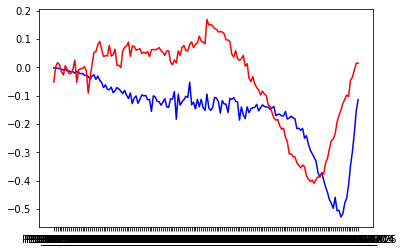

In [343]:
plt.plot(qoi_pred_iv_df[P12_column_names].iloc[0],'b')
plt.plot(phase400new[P12_column_names].iloc[0],'r')

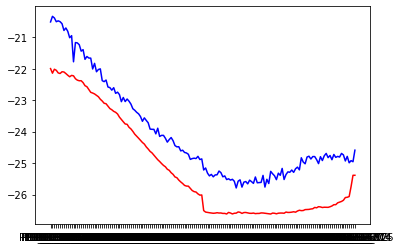

In [344]:
plt.plot(qoi_pred_iv_df[P11_column_names].iloc[0],'b')
plt.plot(phase400new[P11_column_names].iloc[0],'r')

In [345]:
plt.plot(phase_400['angle'],phase_fun400['PPF'],'.')

NameError: name 'phase_400' is not defined

In [ ]:
plt.plot(newpdP11_s.iloc[0])